In [7]:
import time

import numpy as np
from distutils.version import LooseVersion
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage import color
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

# these were introduced in skimage-0.14
import Dataset
if LooseVersion(skimage.__version__) >= '0.14':
    rescale_params = {'anti_aliasing': False, 'multichannel': False}
else:
    rescale_params = {}

# load the coins as a numpy array
orig_coins = Dataset.load_by_path('test.png')
orig_coins = color.rgb2gray(orig_coins)
# orig_coins = coins()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.

smoothened_coins = gaussian_filter(orig_coins, sigma=2)
# rescaled_coins = rescale(smoothened_coins, 0.8, mode="reflect",
#                          **rescale_params)

rescaled_coins = smoothened_coins 

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(rescaled_coins)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 15
eps = 1e-5
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 10



Spectral clustering: kmeans, 6.26s
Spectral clustering: discretize, 6.93s


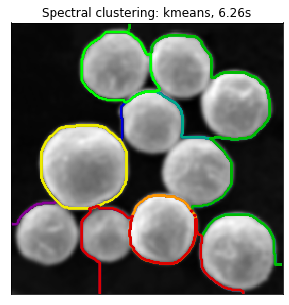

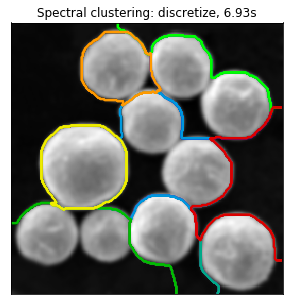

In [8]:
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph,
                                 n_clusters=N_REGIONS, 
                                 eigen_solver='amg',
                                 assign_labels=assign_labels, 
                                 random_state=42,
                                 n_init=1)
    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l,
                    colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = 'Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()
